In [1]:
# Run this if in Google Colab
# !git clone https://github.com/git-sunao/path-integral.git
# %cd path-integral
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from getdist import MCSamples, plots

import sys
import os
sys.path.append("../")
from pldflow import plflow
from pldflow import sampler

/Users/sugiyamasunao/miniconda3/envs/pyplint/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Example: Point lens

In [4]:
class PointLens(plflow.PicardLefschetzModelBaseClass):
    # Here the ndim is the dimension of x. 
    ndim = 2
    def action_s(self, z, y, w=1):
        geo = 0.5*jnp.dot(z-y,z-y)
        pot = jnp.log(jnp.dot(z,z)**0.5)
        return -1j * w * (geo - pot)

Before we jump in the sampling, we should carefully choose the maximum time.

As PL time increase, the integrand gets less oscilate and easier to be integrated, but beyond some point, 
the width of the peak becomes too narrow makes it really difficult to be sampled efficiently.

Based on the assumption that the width of the peak should be same for higher dimension,
we determine the best maximum flow time so that we can get less oscillating function and not-too-narrow peak.

(Probably this can be done automatically, by requiring that $W_x/\Delta x \sim 1$, where $W_x$ is the width of a peak and $\Delta x$ is the typical scale of the oscilation of the original integrand.)

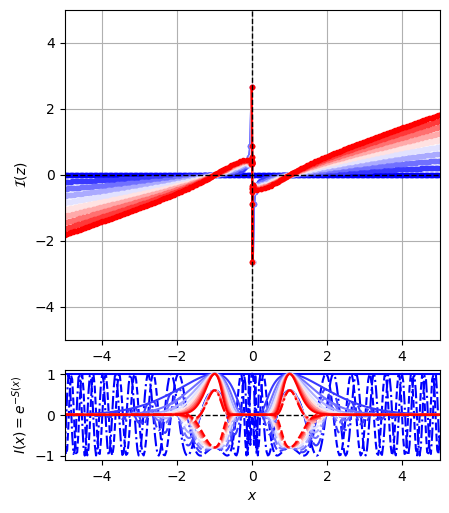

In [16]:
w = 5.0
tmax = 0.4
ntbin= 10

# instantiate the model
pl = PointLens(ndim=1)

t = jnp.linspace(0, tmax/w, ntbin)
x = jnp.linspace(-5,5,300).reshape(-1,1)
y = jnp.array([0.0])

fig, axes = pl.plot1d(x,t=t,y=y, w=w)
# Okay from this plot, we see that tmax=0.2 is large enough 
# to make the integrand less oscilating.
# And using larger tmax makes the peak width too small 
# making it difficult to sample efficint.

In [6]:
pl = PointLens(ndim=2)

## Conditional Sampler

In [7]:
# we define the log likelihood to be sampled

# PL flow time
t = jnp.linspace(0, tmax/w, ntbin)

def like(x, y):
    z = pl.flow(x=x, t=t, y=y, w=w)
    j = pl.flow_jacobian(x=x, t=t, y=y, w=w)
    return -pl.action_s(z, y).real + jnp.log(jnp.abs(j))

In [8]:
# Define the range of variable to sample
# The format is 
# {'x':(min, max, ndim)}
xranges = {'x':(-7,7,pl.ndim), 'y':(-5, 5, pl.ndim)}
# Instantiate the sampler
csampler = sampler.ConditionallikelihoodSampler(like, xranges)

In [9]:
# turn off
import warnings
warnings.filterwarnings("ignore", message="There are not enough devices to run parallel chains")

# Now sample using Hamiltonian Monte Carlo
# Inputs are (num_warmup, num_xsamples, num_chains)
# - num_warmup: number of warmup samples (i.e. burnin)
# - num_xsamples: number of samples to draw per chain
# - num_chains: number of chains (this shoulbe large especially when multimodal, to avoid local minima)
%time csampler.sample_xsamples(100, 70, 70, progress_bar=True)

# this will give you 70*70=4900 samples

sample: 100%|██████████| 170/170 [00:01<00:00, 106.28it/s, 31 steps of size 6.24e-02. acc. prob=0.98]


CPU times: user 4min 40s, sys: 38 s, total: 5min 18s
Wall time: 3min 51s


Removed no burn in


<Figure size 600x600 with 0 Axes>

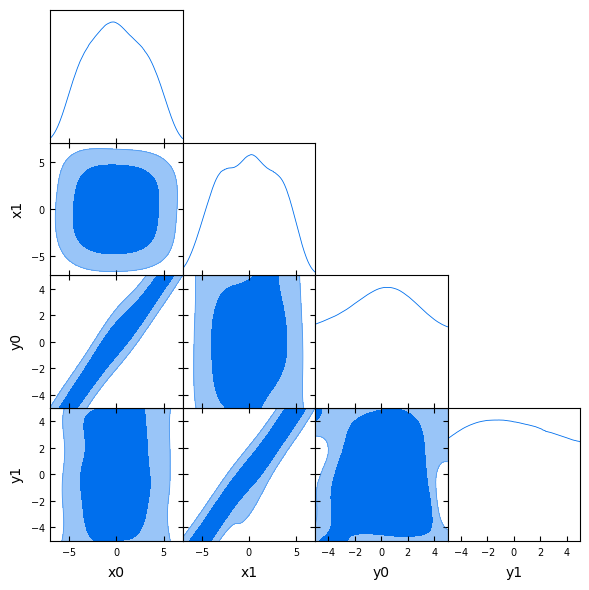

In [19]:
# Show the distribution
mcs = MCSamples(samples=csampler.xsamples, names=csampler.xnames, ranges=csampler.xranges)

g = plots.get_single_plotter(ratio=1)
g.triangle_plot([mcs], filled=True)
plt.show()

In [20]:
# If you want to control `y` to be uniform using the Sobol sequene, we insted do

# xranges = {'x':(-7,7,fresnel.ndim)}
# pranges = {'y':(-5,5,fresnel.ndim)}
# csampler = sampler.ConditionallikelihoodSampler(like, xranges, pranges)
# csampler.sample_xpsamples(50, 50, 10, num_psamples=10, xprogress_bar=True, pprogress_bar=False)

# In this example we smaple num_psamples=10 `y` using Sobol sequence.

## NDE (normalizing flow)

In [21]:
# In the above analysis, we treated x and y as random variables.
# The first half of the `xsamples` in `csmapler` are x samples, and the second half are y samples.
xsamples = csampler.xsamples[:,:pl.ndim]
ysamples = csampler.xsamples[:,pl.ndim:]
print(xsamples.shape, ysamples.shape)

# Using these samples of (x,y), we train Normalizing Flow
nde = sampler.NDESampler(xsamples, ysamples, normalize=True, decorrelate=False)

(4900, 2) (4900, 2)


In [22]:
# Neural Spline Flow
nde.buildNSF(hidden_dims=[32]*4, n_transforms=6, range_min=-3, range_max=3, n_bins=10)

# Masked Autoregressive Flow (for now this is failing for some reason, need to be investigated)
# nde.buildMAF(hidden_dims=[32]*10, n_transforms=8)

In [23]:
# Train the network
%time nde.train(patience=20, n_steps=1000, min_delta=0.1, batch_size=512)

Training MAF: 100%|██████████| 1000/1000 [00:31<00:00, 31.71it/s]

CPU times: user 1min 2s, sys: 4.45 s, total: 1min 7s
Wall time: 36.3 s


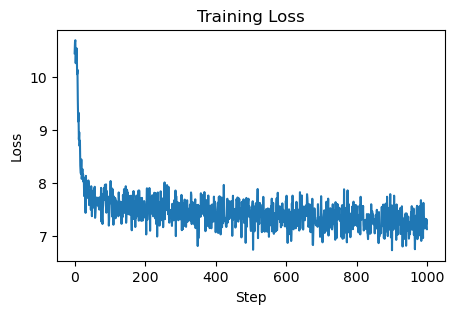

In [24]:
nde.plot_loss()

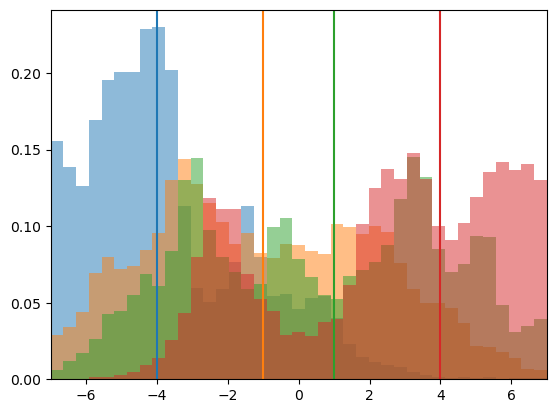

In [25]:
# Now let's see the trained conditional distribution
# In this example we chage the first dimension of y to be -4, -1, 1, 4
# and plot the histgram of the first dimension of x samples

bins = jnp.linspace(xranges['x'][0], xranges['x'][1], 40)
for i, y1 in enumerate([-4.0, -1.0, 1.0, 4.0]):
    y = jnp.array([y1, 0.0])
    xsamples_nde = nde.sample(y, num_samples=20_000)
    plt.hist(xsamples_nde[:,0], bins=bins, alpha=0.5, density=True, color='C%d'%i)
    plt.axvline(y1, color='C%d'%i)
plt.xlim(xranges['x'][:2])
plt.show()

## Lets perform the integral using the importance sampling

In [34]:
def perform(y, num_samples=5_000):
    # generate samples and log probability
    x, lnp = nde.sample_and_log_prob(y, num_samples=num_samples, seed=2)
    # perform integral using the samples
    Z, dZ  = pl.integrate(x, lnp, t, y=y, w=w, error=True)
    return Z, dZ
# vectorize the function
vperform = jax.vmap(perform, in_axes=0, out_axes=0)

In [36]:
# Again, we change the first dimension of y, y=(y1, y2) with y2=0
# y1 = jnp.logspace(-1, jnp.log10(10.0), 200)
y1 = jnp.linspace(0.0, 10.0, 200)
y2 = jnp.zeros_like(y1)
y  = jnp.stack([y1]+[y2], axis=1)
%time Z, dZ = vperform(y)

CPU times: user 21 s, sys: 2.15 s, total: 23.1 s
Wall time: 6.07 s


In [37]:
def get_analytic(y1, w):
    fname = '../data/Fpl_w{:.1f}.dat'.format(w)
    assert os.path.exists(fname), 'Analytic solution not found'
    import numpy
    y, fpl_r, fpl_i = numpy.loadtxt(fname, unpack=True)
    fpl = fpl_r + 1j*fpl_i
    return jnp.interp(y1, y, fpl)
Za = get_analytic(y1, w)

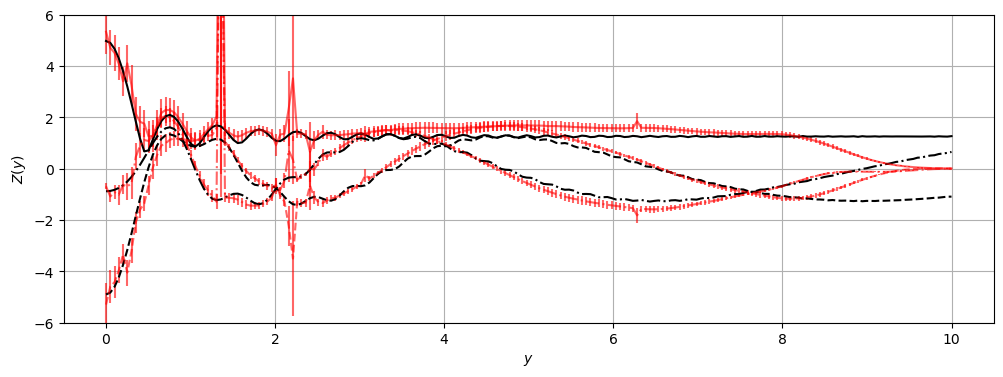

In [ ]:
# Plotting
plt.figure(figsize=(12, 4))
# estimate
plt.errorbar(y1, jnp.real(Z), jnp.real(dZ), color='r', ls='--', alpha=0.6)
plt.errorbar(y1, jnp.imag(Z), jnp.imag(dZ), color='r', ls='-.', alpha=0.6)
plt.errorbar(y1, jnp.abs(Z) , jnp.abs(dZ) , color='r', ls='-' , alpha=0.6)
# exact
plt.plot(y1, jnp.real(Za), color='k', ls='--')
plt.plot(y1, jnp.imag(Za), color='k', ls='-.')
plt.plot(y1, jnp.abs(Za) , color='k', ls='-')

plt.ylim(-6,6)
plt.grid()
plt.xlabel(r'$y$')
plt.ylabel(r'$Z(y)$')
plt.show()